In [1]:
!git clone https://github.com/ISorokos/SafeML.git

fatal: destination path 'SafeML' already exists and is not an empty directory.


In [50]:
import sys
sys.path.insert(1, './SafeML/Implementation_in_Python')

# Importing local modules (statistical distance measures)
from CVM_Distance import CVM_Dist as Cramer_Von_Mises_Dist
from Anderson_Darling_Distance import Anderson_Darling_Dist
from Kolmogorov_Smirnov_Distance import Kolmogorov_Smirnov_Dist
from KuiperDistance import Kuiper_Dist
from WassersteinDistance import Wasserstein_Dist
from DTS_Distance import DTS_Dist # Combo of Anderson_Darling and CVM distance.
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


In [3]:
%matplotlib inline
import os, sys # For accessing Python Modules in the System Path (for accessing the Statistical Measures modules)
# See: https://stackoverflow.com/a/39311677
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import pandas as pd # For DataFrames, Series, and reading csv data in.
import seaborn as sns # Graphing, built ontop of MatPlot for ease-of-use and nicer diagrams.
import matplotlib.pyplot as plt # MatPlotLib for graphing data visually. Seaborn more likely to be used.
import numpy as np # For manipulating arrays and changing data into correct formats for certain libraries
import sklearn # For Machine Learning algorithms
import scikitplot # Confusion matrix plotting
from sklearn.decomposition import PCA # For PCA dimensionality reduction technique
from sklearn.preprocessing import StandardScaler # For scaling to unit scale, before PCA application
from sklearn.preprocessing import LabelEncoder # For converting categorical data into numeric, for modeling stage
from sklearn.model_selection import StratifiedKFold # For optimal train_test splitting, for model input data
from sklearn.model_selection import train_test_split # For basic dataset splitting
from sklearn.neighbors import KNeighborsClassifier # K-Nearest Neighbors ML classifier (default n. of neighbors = 5)
from scikitplot.metrics import plot_confusion_matrix # For plotting confusion matrices
from sklearn.metrics import accuracy_score # For getting the accuracy of a model's predictions
from sklearn.metrics import classification_report # Various metrics for model performance
from sklearn.neural_network import MLPClassifier # For Neural Network classifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [4]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep]

In [5]:
def get_PCA_feature_names(num_of_pca_components):
    feature_names = []
    for i in range(num_of_pca_components):    
        feature_names.append(f"Principal component {i+1}")
    return feature_names

In [7]:
# See documentation above to understand what each step does, and why.
def train_model_predict(model, model_name, X, y, skf):
    for train_index, test_index in skf.split(X, y): # 1)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index] # 2)
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        reshaped_y_train = np.asarray(y_train).reshape(-1, 1) # 3)
        reshaped_y_test = np.asarray(y_test).reshape(-1, 1)
        
    model.fit(X_train, reshaped_y_train.ravel()) # 4)
    pred_y = model.predict(X_test) # 5)
    score = classification_report(reshaped_y_test, pred_y) # 6)
    print('Classification report: \n', score, '\n')
    plot_confusion_matrix(reshaped_y_test, pred_y, title='Confusion Matrix for {}'.format(model_name))
        
    return accuracy_score(reshaped_y_test, pred_y), X_train, X_test, y_train, pred_y

In [8]:
def get_shuffled_stratifiedKFold_train_test_split(X, y):
    # Shuffle to True, to get different shuffles each time. Permutations being varied is the goal here.
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    
    # For loop to get index for training and test data, using StratifiedKFold (3 splits)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # NOTE: Sometimes 'reshape' needed for label, so that the model can use it (required in SciKit)
        #reshaped_y_train = np.asarray(y_train).reshape(-1, 1)
        #reshaped_y_test = np.asarray(y_test).reshape(-1, 1)
        
    # After for loop ends, all training and test data has been retrieved thus can return it.
    return X_train, X_test, y_train, y_test

In [9]:
def train_and_predict_Neural_Network_MLP_model(X_train, X_test, y_train, y_test):
    # Instantiating new Neural Network classifier and setting Hyperparameters
    Neural_Net_model = MLPClassifier(hidden_layer_sizes=(10,), activation='relu',
                                    solver='adam', alpha=0.01, batch_size='auto',
                                    learning_rate='adaptive', learning_rate_init=0.1,
                                    max_iter=2)
    
    # Fitting the model is synonymous to training the model. Need to call .ravel() to get array in correct format.
    Neural_Net_model.fit(X_train, y_train.ravel())
    
    # Using the model to predict the label/ classes, based upon X_test data only. This is the model's answers.
    pred_y = Neural_Net_model.predict(X_test) 
    
    # Returning model answers and the accuracy of the model i.e. how well it predicts the answers.
    return pred_y, accuracy_score(y_test, pred_y)

In [10]:
import lightgbm as lgb

def train_and_predict_LGB(X_train, X_test, y_train, y_test):
    # Instantiating new Light GBM classifier and setting Hyperparameters
    lgb_params = {'n_estimators':1000,
                  'boosting_type': 'gbdt',
                  'objective': 'binary',
                  'metric': 'auc',
                 }
    #Defining the training dataset
    lgb_data = lgb.Dataset(X_train, y_train)
    
    #Training the Light GBM classifier
    bst = lgb.train(lgb_params, lgb_data)
    
    # Using the model to predict the label/ classes, based upon X_test data only. This is the model's answers.
    pred_y = bst.predict(X_test) 
    
    # Evaluate AUC Score
    from sklearn.metrics import roc_auc_score
    
    # Returning model answers and the accuracy of the model i.e. how well it predicts the answers.
    return pred_y, roc_auc_score(y_test, pred_y)

In [11]:
# send to top and add documentation
def get_statistical_dist_measures_for_class_result(accuracy, X_train_L, X_test_L):
    # Can use this to loop over all the features, since the ECDF Python methods are currently Univariate only
    num_of_features = len(X_train_L.columns)
    
    # Instantiate empty arrays with large enough size, to hold statistical distance data
    CVM_distances = np.zeros(num_of_features)
    Anderson_Darling_distances = np.zeros(num_of_features)
    Kolmogorov_Smirnov_distances = np.zeros(num_of_features)
    Kuiper_distances = np.zeros(num_of_features)
    Wasserstein_distances = np.zeros(num_of_features)
    DTS_distances = np.zeros(num_of_features)

    for i in range(0, num_of_features):
        # iloc[:, i] allows selection of the ith feature in the Pandas dataframe
        # Calling the methods from the imported Python modules (see import section at top of notebook)
        CVM_distances[i] = Cramer_Von_Mises_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        Anderson_Darling_distances[i] = Anderson_Darling_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        Kolmogorov_Smirnov_distances[i] = Kolmogorov_Smirnov_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        Kuiper_distances[i] = Kuiper_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        Wasserstein_distances[i] = Wasserstein_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        DTS_distances[i] = DTS_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        
    # Computing mean/ average, to get ECDF distance of full dataset. Float64 to keep accuracy high.
    # See: https://numpy.org/doc/stable/reference/generated/numpy.mean.html
    CVM_distance = np.mean(CVM_distances, dtype=np.float64)
    Anderson_Darling_distance = np.mean(Anderson_Darling_distances, dtype=np.float64)
    Kolmogorov_Smirnov_distance = np.mean(Kolmogorov_Smirnov_distances, dtype=np.float64)
    Kuiper_distance = np.mean(Kuiper_distances, dtype=np.float64)
    Wasserstein_distance = np.mean(Wasserstein_distances, dtype=np.float64)
    DTS_distance = np.mean(DTS_distances, dtype=np.float64)
    
    # Returning dictionary, for efficient and fast DataFrame creation. Returns mean for each distance.
    # See https://stackoverflow.com/a/17496530. Fast way to 'append' to dataframe for results table.
    # PRESERVE THE ORDERING
    return {'Accuracy': accuracy,
            'Anderson_Darling_dist': Anderson_Darling_distance,
            'CVM_dist': CVM_distance,
            'DTS_dist':DTS_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance,
            'Kuiper_dist': Kuiper_distance,
            'Wasserstein_dist': Wasserstein_distance}

In [12]:
def get_X_train_and_test_data_for_given_label(labels, label_index, pred_y, X_train, X_test, y_train, y_test):
    X_train_loc_for_label = X_train.loc[y_train == labels[label_index]]
    X_test_loc_for_label = X_test.loc[pred_y == labels[label_index]]
    
    return X_train_loc_for_label, X_test_loc_for_label

In [13]:
# Using f-strings: https://www.journaldev.com/23642/python-concatenate-string-and-int
def get_concatenated_results_holding_all_classes_results(number_of_classes, result_dataframes):
    # Empty list to dynamically hold the dataframes which have been assigned a new dataset column
    dataframes = []
    
    # For each class/ label
    for i in range(number_of_classes):
        class_name = f'class{i}'
        dataframes.append(result_dataframes[i].assign(dataset = class_name))
    
    concatenated = pd.concat(dataframes)
    
    return concatenated

In [14]:
# 'Reduced dimensions' variable for altering the number of PCA principal components. Can be altered for needs.
# Only 7 principal components needed when using non-normalised PCA dataset.
dimensions_num_for_PCA = 7

# Max number of permutations to run. Can be altered for needs.
number_of_permutations = 100

# 10 folds is usually the heuristic to follow for larger datasets of around this size.
num_of_splits_for_skf = 10

# Seed value to pass into models so that repeated runs result in the same output
seed_val = 1

# Number of statistical distance measures to run (for the results, columns section)
num_of_statistical_dist_measures = 6

In [15]:
# The .csv dataset file should be in the same project directory as this Jupyter Notebook file
# Friday_Morning_Data = pd.read_csv('../input/cicids2017/MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
# df = Friday_Morning_Data.copy()

df = pd.concat(map(pd.read_csv, ['./MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 
                                 './MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 
                                 './MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv', 
                                 './MachineLearningCSV/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv', 
                                 './MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 
                                 './MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 
                                 './MachineLearningCSV/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv', 
                                 './MachineLearningCSV/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv']), 
               ignore_index = True)

print("Datatype of Dataframe i.e. Pandas Dataframe: ", type(df))
print("Datatype of Column i.e. Pandas Series: ", type(df.iloc[:, 1]))
df.head()

Datatype of Dataframe i.e. Pandas Dataframe:  <class 'pandas.core.frame.DataFrame'>
Datatype of Column i.e. Pandas Series:  <class 'pandas.core.series.Series'>


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [16]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [17]:
df.dtypes

destination_port                 int64
flow_duration                    int64
total_fwd_packets                int64
total_backward_packets           int64
total_length_of_fwd_packets      int64
                                ...   
idle_mean                      float64
idle_std                       float64
idle_max                         int64
idle_min                         int64
label                           object
Length: 79, dtype: object

In [18]:
df_cleaned = df.copy()
df_cleaned = clean_dataset(df_cleaned) # see methods at top of notebook
df_cleaned


,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,53,32215,4,2,112,152,28,28,28.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,53,324,2,2,84,362,42,42,42.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,58030,82,2,1,31,6,31,0,15.500000,21.920310,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,53,1048635,6,2,192,256,32,32,32.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [19]:
df_cleaned = df_cleaned.reset_index()
# Removing un-needed index column added by reset_index method
df_cleaned.drop('index', axis=1, inplace=True)
df_cleaned

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827871,53,32215,4,2,112,152,28,28,28.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2827872,53,324,2,2,84,362,42,42,42.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2827873,58030,82,2,1,31,6,31,0,15.500000,21.920310,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2827874,53,1048635,6,2,192,256,32,32,32.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [20]:
df.columns.tolist()

['destination_port',
 'flow_duration',
 'total_fwd_packets',
 'total_backward_packets',
 'total_length_of_fwd_packets',
 'total_length_of_bwd_packets',
 'fwd_packet_length_max',
 'fwd_packet_length_min',
 'fwd_packet_length_mean',
 'fwd_packet_length_std',
 'bwd_packet_length_max',
 'bwd_packet_length_min',
 'bwd_packet_length_mean',
 'bwd_packet_length_std',
 'flow_bytes/s',
 'flow_packets/s',
 'flow_iat_mean',
 'flow_iat_std',
 'flow_iat_max',
 'flow_iat_min',
 'fwd_iat_total',
 'fwd_iat_mean',
 'fwd_iat_std',
 'fwd_iat_max',
 'fwd_iat_min',
 'bwd_iat_total',
 'bwd_iat_mean',
 'bwd_iat_std',
 'bwd_iat_max',
 'bwd_iat_min',
 'fwd_psh_flags',
 'bwd_psh_flags',
 'fwd_urg_flags',
 'bwd_urg_flags',
 'fwd_header_length',
 'bwd_header_length',
 'fwd_packets/s',
 'bwd_packets/s',
 'min_packet_length',
 'max_packet_length',
 'packet_length_mean',
 'packet_length_std',
 'packet_length_variance',
 'fin_flag_count',
 'syn_flag_count',
 'rst_flag_count',
 'psh_flag_count',
 'ack_flag_count',
 'ur

In [21]:
# Saving the label attribute before dropping it.
df_labels = df_cleaned['label']
# Shows all the possible labels/ classes a model can predict.
# Need to alter these to numeric 0, 1, etc... for model comprehension (e.g. pd.get_dummies()).
df_labels.unique()

array(['BENIGN', 'PortScan', 'DDoS', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

In [22]:
# Axis=1 means columns. Axis=0 means rows. inplace=False means that the original 'df' isn't altered.
df_no_labels = df_cleaned.drop('label', axis=1, inplace=False)
# Getting feature names for the StandardScaler process
df_features = df_no_labels.columns.tolist()
# Printing out Dataframe with no label column, to show successful dropping
df_no_labels

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827871,53,32215,4,2,112,152,28,28,28.000000,0.000000,...,3,20,0.0,0.0,0,0,0.0,0.0,0,0
2827872,53,324,2,2,84,362,42,42,42.000000,0.000000,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
2827873,58030,82,2,1,31,6,31,0,15.500000,21.920310,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
2827874,53,1048635,6,2,192,256,32,32,32.000000,0.000000,...,5,20,0.0,0.0,0,0,0.0,0.0,0,0


In [23]:
df_scaled = StandardScaler().fit_transform(df_no_labels)
# Converting back to dataframe
df_scaled = pd.DataFrame(data = df_scaled, columns = df_features)
df_scaled

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,-0.439936,-0.401999,0.042172,0.033667,0.211444,-0.004074,0.345908,-0.310317,0.036092,0.145337,...,0.029174,0.002558,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184
1,-0.439936,-0.400425,0.042172,0.033667,0.211444,-0.004074,0.345908,-0.310317,0.036092,0.145337,...,0.029174,0.002558,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184
2,-0.439936,-0.439608,-0.011158,-0.009424,-0.054993,-0.007145,-0.289616,-0.310317,-0.312914,-0.245193,...,-0.008518,0.002558,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184
3,-0.439936,-0.400896,0.042172,0.031663,0.217844,-0.004216,0.345908,-0.310317,0.044476,0.146281,...,0.029174,0.002558,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184
4,1.495786,-0.439610,-0.011158,-0.008422,-0.054993,-0.007145,-0.289616,-0.310317,-0.312914,-0.245193,...,-0.008518,0.002558,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827871,-0.438240,-0.438656,-0.007158,-0.008422,-0.043791,-0.007078,-0.250592,0.153602,-0.162517,-0.245193,...,-0.003806,0.002547,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184
2827872,-0.438240,-0.439603,-0.009825,-0.008422,-0.046592,-0.006986,-0.231080,0.385562,-0.087318,-0.245193,...,-0.006947,0.002547,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184
2827873,2.734355,-0.439610,-0.009825,-0.009424,-0.051892,-0.007143,-0.246411,-0.310317,-0.229658,-0.167274,...,-0.008518,0.002558,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184
2827874,-0.438240,-0.408466,-0.004492,-0.008422,-0.035790,-0.007032,-0.245017,0.219876,-0.141031,-0.245193,...,-0.000665,0.002547,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184


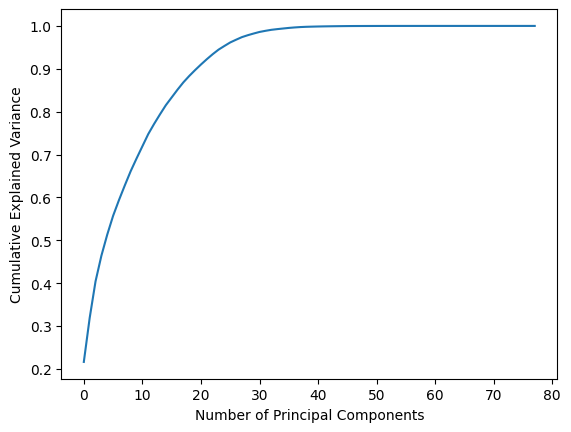

In [24]:
pca_test = PCA().fit(df_scaled)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

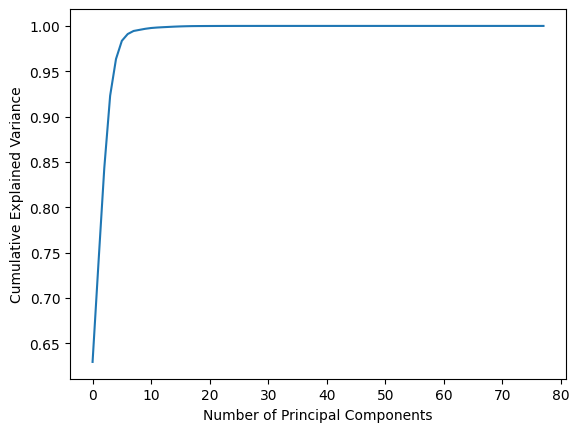

In [25]:
# The df_no_labels dataset holds the un-normalised dataset.
pca_test = PCA().fit(df_no_labels)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [26]:
pca = PCA(n_components=dimensions_num_for_PCA)
#principal_components = pca.fit(df_scaled).transform(df_scaled) => for normalised PCA

# Non-normalised PCA
principal_components = pca.fit(df_no_labels).transform(df_no_labels)
principal_components

array([[-2.89703062e+07, -2.13694225e+06, -3.31155477e+04, ...,
         3.31612144e+05, -2.66647959e+05,  3.06874165e+05],
       [-2.89083912e+07, -2.07791247e+06, -3.32596733e+04, ...,
         3.14009230e+05, -2.56614201e+05,  3.06519759e+05],
       [-3.08252886e+07, -2.54637122e+06, -3.07730122e+04, ...,
         9.54961423e+05, -6.03447048e+05, -3.16673807e+05],
       ...,
       [-3.08298437e+07, -2.55358509e+06, -3.08732491e+04, ...,
         9.53079628e+05, -6.02690687e+05, -3.16378507e+05],
       [-2.91790417e+07, -2.55858025e+06, -3.03308252e+04, ...,
         3.59838667e+05, -1.78350983e+05,  3.90106436e+05],
       [-3.06956187e+07, -2.54434066e+06, -3.08399223e+04, ...,
         9.09082356e+05, -5.66415383e+05, -2.62152326e+05]])

In [27]:
# See Methods at the top of the notebook
principal_component_headings = get_PCA_feature_names(dimensions_num_for_PCA)

In [28]:
df_pc = pd.DataFrame(data = principal_components, columns = principal_component_headings)
df_pc

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7
0,-2.897031e+07,-2.136942e+06,-33115.547667,-1.805179e+06,331612.143769,-266647.959356,306874.164786
1,-2.890839e+07,-2.077912e+06,-33259.673311,-1.804023e+06,314009.230250,-256614.200580,306519.759479
2,-3.082529e+07,-2.546371e+06,-30773.012224,-1.833546e+06,954961.422721,-603447.047730,-316673.807029
3,-2.892029e+07,-2.096910e+06,-33217.148590,-1.804430e+06,337575.435202,-273922.857729,314964.218203
4,-3.082535e+07,-2.546339e+06,-30773.354622,-1.833471e+06,955061.458540,-603503.120799,-316734.588604
...,...,...,...,...,...,...,...
2827871,-3.077420e+07,-2.548007e+06,-30822.419757,-1.825043e+06,937832.133861,-589571.196769,-294109.388375
2827872,-3.083878e+07,-2.568404e+06,-30951.600908,-4.572670e+05,949028.056552,-601022.299393,-315503.329672
2827873,-3.082984e+07,-2.553585e+06,-30873.249129,-1.382320e+06,953079.628456,-602690.687234,-316378.507345
2827874,-2.917904e+07,-2.558580e+06,-30330.825163,-1.821424e+06,359838.667425,-178350.982734,390106.436002


In [29]:
df_final = pd.concat([df_pc, df_labels], axis = 1)
# Scroll to the RHS end of dataframe to see attached label feature
df_final

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,label
0,-2.897031e+07,-2.136942e+06,-33115.547667,-1.805179e+06,331612.143769,-266647.959356,306874.164786,BENIGN
1,-2.890839e+07,-2.077912e+06,-33259.673311,-1.804023e+06,314009.230250,-256614.200580,306519.759479,BENIGN
2,-3.082529e+07,-2.546371e+06,-30773.012224,-1.833546e+06,954961.422721,-603447.047730,-316673.807029,BENIGN
3,-2.892029e+07,-2.096910e+06,-33217.148590,-1.804430e+06,337575.435202,-273922.857729,314964.218203,BENIGN
4,-3.082535e+07,-2.546339e+06,-30773.354622,-1.833471e+06,955061.458540,-603503.120799,-316734.588604,BENIGN
...,...,...,...,...,...,...,...,...
2827871,-3.077420e+07,-2.548007e+06,-30822.419757,-1.825043e+06,937832.133861,-589571.196769,-294109.388375,BENIGN
2827872,-3.083878e+07,-2.568404e+06,-30951.600908,-4.572670e+05,949028.056552,-601022.299393,-315503.329672,BENIGN
2827873,-3.082984e+07,-2.553585e+06,-30873.249129,-1.382320e+06,953079.628456,-602690.687234,-316378.507345,BENIGN
2827874,-2.917904e+07,-2.558580e+06,-30330.825163,-1.821424e+06,359838.667425,-178350.982734,390106.436002,BENIGN


In [30]:
le = LabelEncoder()
df_final['label'] = le.fit_transform(df_final['label'])

df_final

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,label
0,-2.897031e+07,-2.136942e+06,-33115.547667,-1.805179e+06,331612.143769,-266647.959356,306874.164786,0
1,-2.890839e+07,-2.077912e+06,-33259.673311,-1.804023e+06,314009.230250,-256614.200580,306519.759479,0
2,-3.082529e+07,-2.546371e+06,-30773.012224,-1.833546e+06,954961.422721,-603447.047730,-316673.807029,0
3,-2.892029e+07,-2.096910e+06,-33217.148590,-1.804430e+06,337575.435202,-273922.857729,314964.218203,0
4,-3.082535e+07,-2.546339e+06,-30773.354622,-1.833471e+06,955061.458540,-603503.120799,-316734.588604,0
...,...,...,...,...,...,...,...,...
2827871,-3.077420e+07,-2.548007e+06,-30822.419757,-1.825043e+06,937832.133861,-589571.196769,-294109.388375,0
2827872,-3.083878e+07,-2.568404e+06,-30951.600908,-4.572670e+05,949028.056552,-601022.299393,-315503.329672,0
2827873,-3.082984e+07,-2.553585e+06,-30873.249129,-1.382320e+06,953079.628456,-602690.687234,-316378.507345,0
2827874,-2.917904e+07,-2.558580e+06,-30330.825163,-1.821424e+06,359838.667425,-178350.982734,390106.436002,0


In [31]:
print("Before LabelEncoder: ", df_labels.unique())
print("After LabelEncoder: ", df_final['label'].unique())

Before LabelEncoder:  ['BENIGN' 'PortScan' 'DDoS' 'Bot' 'Infiltration'
 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed']
After LabelEncoder:  [ 0 10  2  1  9 12 14 13  7 11  6  5  4  3  8]


In [32]:
df_labels.value_counts()

label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [33]:
# Separating the label so that the answers aren't provided to the model, in training.
X = df_final.drop(['label'], axis = 1)
y = df_final['label']
y

0          0
1          0
2          0
3          0
4          0
          ..
2827871    0
2827872    0
2827873    0
2827874    0
2827875    0
Name: label, Length: 2827876, dtype: int64

In [34]:
skf = StratifiedKFold(n_splits=num_of_splits_for_skf, shuffle=False)
skf

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [35]:
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    reshaped_y_train = np.asarray(y_train).reshape(-1, 1)
    reshaped_y_test = np.asarray(y_test).reshape(-1, 1)
    
print( 'X_train length: ', len(X_train) ) # To check if splits worked
print( 'y_train length: ', len(y_train) )
print( 'X_test length: ', len(X_test) )
print( 'y_test length: ', len(y_test) )

X_train length:  2545089
y_train length:  2545089
X_test length:  282787
y_test length:  282787


In [36]:
knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform',
                                    algorithm='auto', leaf_size=30,
                                    p=2, metric='minkowski',
                                    metric_params=None, n_jobs=None)

Classification report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    227132
           1       0.37      0.16      0.22       196
           2       0.98      0.96      0.97     12802
           3       0.96      0.97      0.96      1029
           4       0.98      0.72      0.83     23013
           5       0.76      0.85      0.80       550
           6       0.84      0.21      0.33       579
           7       0.98      0.91      0.95       793
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         4
          10       0.96      1.00      0.98     15880
          11       0.95      0.91      0.93       590
          12       0.68      0.69      0.68       150
          13       0.00      0.00      0.00         2
          14       0.23      0.14      0.17        66

    accuracy                           0.97    282787
   macro avg       0.64      0.57      0.59    282787
w

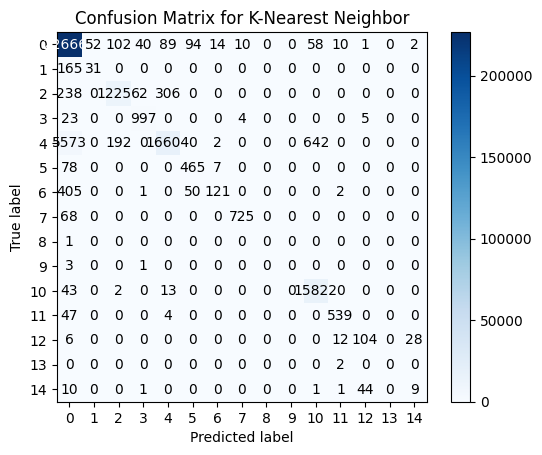

In [42]:
# Unpacking the method return values. Last 4 are needed for statistical distance measure methods.
accuracy, X_train, X_test, y_train, pred_y = train_model_predict(knn_model, "K-Nearest Neighbor", X, y, skf)
print("Model accuracy= ", accuracy*100, "%\n")
print("Dataset labels: ", df_labels.unique())
print("Dataset numeric labels after encoding for model: ", df_final['label'].unique())

In [40]:
rf_classifier = RandomForestClassifier(n_estimators=5, random_state=42)

Classification report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99    227132
           1       0.42      0.20      0.27       196
           2       0.99      0.97      0.98     12802
           3       0.93      0.96      0.94      1029
           4       0.99      0.76      0.86     23013
           5       0.84      0.86      0.85       550
           6       0.78      0.20      0.32       579
           7       1.00      0.94      0.97       793
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         4
          10       0.97      1.00      0.98     15880
          11       0.97      0.91      0.94       590
          12       0.68      0.65      0.66       150
          13       0.00      0.00      0.00         2
          14       0.22      0.17      0.19        66

    accuracy                           0.97    282787
   macro avg       0.65      0.57      0.60    282787
w

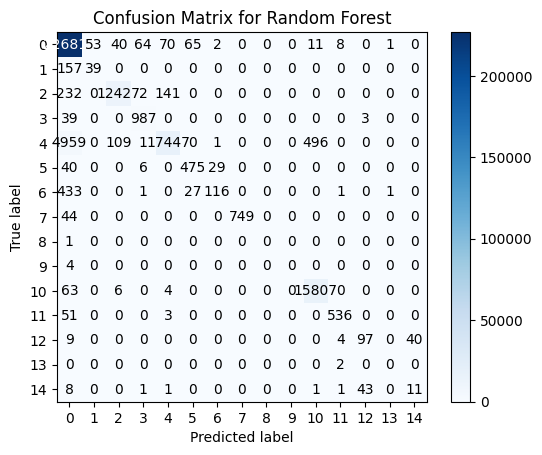

In [41]:
# Unpacking the method return values. Last 4 are needed for statistical distance measure methods.
accuracy, X_train, X_test, y_train, pred_y = train_model_predict(rf_classifier, "Random Forest", X, y, skf)
print("Model accuracy= ", accuracy*100, "%\n")
print("Dataset labels: ", df_labels.unique())
print("Dataset numeric labels after encoding for model: ", df_final['label'].unique())

In [43]:
# Create the Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.02      0.04    227132
           1       0.00      0.00      0.00       196
           2       0.16      0.05      0.08     12802
           3       0.33      0.73      0.46      1029
           4       0.58      0.15      0.24     23013
           5       0.28      0.17      0.21       550
           6       0.04      0.31      0.08       579
           7       0.07      0.56      0.12       793
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         4
          10       0.08      0.98      0.15     15880
          11       0.04      0.51      0.08       590
          12       0.02      0.80      0.04       150
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        66

    accuracy                           0.09    282787
   macro avg       0.17      0.29      0.10    282787
w

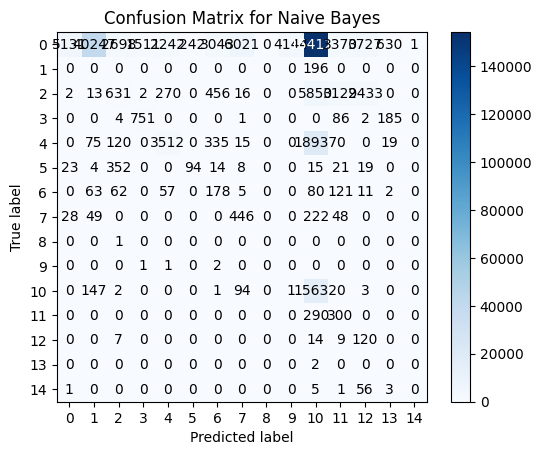

In [44]:
# Unpacking the method return values. Last 4 are needed for statistical distance measure methods.
accuracy, X_train, X_test, y_train, pred_y = train_model_predict(nb_classifier, "Naive Bayes", X, y, skf)
print("Model accuracy= ", accuracy*100, "%\n")
print("Dataset labels: ", df_labels.unique())
print("Dataset numeric labels after encoding for model: ", df_final['label'].unique())

In [54]:
# Create the Logistic Regression classifier
lr_classifier = LogisticRegression()

Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.98      0.90    227132
           1       0.00      0.00      0.00       196
           2       0.48      0.21      0.29     12802
           3       0.00      0.00      0.00      1029
           4       0.57      0.15      0.24     23013
           5       0.46      0.61      0.52       550
           6       0.30      0.31      0.31       579
           7       0.00      0.00      0.00       793
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00     15880
          11       0.00      0.00      0.00       590
          12       0.00      0.00      0.00       150
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        66

    accuracy                           0.81    282787
   macro avg       0.18      0.15      0.15    282787
w

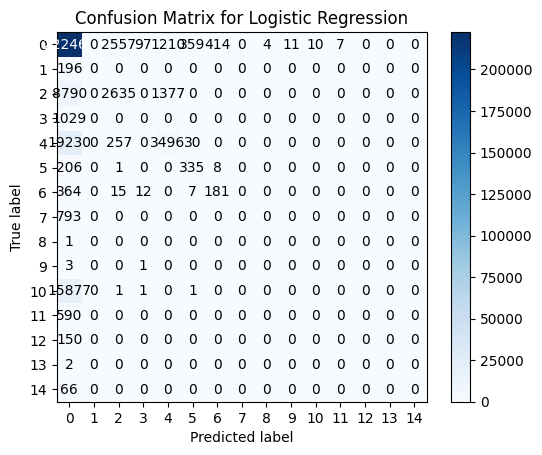

In [55]:
# Unpacking the method return values. Last 4 are needed for statistical distance measure methods.
accuracy, X_train, X_test, y_train, pred_y = train_model_predict(lr_classifier, "Logistic Regression", X, y, skf)
print("Model accuracy= ", accuracy*100, "%\n")
print("Dataset labels: ", df_labels.unique())
print("Dataset numeric labels after encoding for model: ", df_final['label'].unique())

In [56]:
dt_classifier = DecisionTreeClassifier()

Classification report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    227132
           1       0.50      0.29      0.36       196
           2       0.97      0.97      0.97     12802
           3       0.91      0.97      0.94      1029
           4       0.98      0.76      0.86     23013
           5       0.83      0.86      0.84       550
           6       0.84      0.20      0.33       579
           7       0.99      0.94      0.96       793
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         4
          10       0.93      0.99      0.96     15880
          11       0.97      0.91      0.94       590
          12       0.69      0.70      0.70       150
          13       0.00      0.00      0.00         2
          14       0.26      0.18      0.21        66

    accuracy                           0.97    282787
   macro avg       0.66      0.58      0.60    282787
w

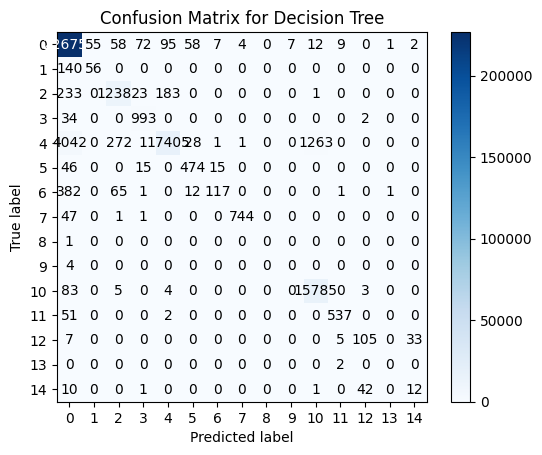

In [57]:
# Unpacking the method return values. Last 4 are needed for statistical distance measure methods.
accuracy, X_train, X_test, y_train, pred_y = train_model_predict(dt_classifier, "Decision Tree", X, y, skf)
print("Model accuracy= ", accuracy*100, "%\n")
print("Dataset labels: ", df_labels.unique())
print("Dataset numeric labels after encoding for model: ", df_final['label'].unique())

In [45]:
# Extracting the number of classes and labels from the label feature
class_num = len(df_final['label'].unique())
labels = df_final['label'].unique()
print("Number of classes: ", class_num)
print("Labels: ", labels)

Number of classes:  15
Labels:  [ 0 10  2  1  9 12 14 13  7 11  6  5  4  3  8]


In [46]:
X_train

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7
0,-2.897031e+07,-2.136942e+06,-33115.547657,-1.805179e+06,3.316121e+05,-2.666480e+05,306874.164786
1,-2.890839e+07,-2.077912e+06,-33259.673301,-1.804023e+06,3.140092e+05,-2.566142e+05,306519.759479
2,-3.082529e+07,-2.546371e+06,-30773.012211,-1.833546e+06,9.549614e+05,-6.034470e+05,-316673.807029
3,-2.892029e+07,-2.096910e+06,-33217.148580,-1.804430e+06,3.375754e+05,-2.739229e+05,314964.218203
4,-3.082535e+07,-2.546339e+06,-30773.354609,-1.833471e+06,9.550615e+05,-6.035031e+05,-316734.588604
...,...,...,...,...,...,...,...
2807931,-7.886318e+06,9.200612e+05,-42731.045716,-1.528131e+06,4.309411e+06,-4.516095e+06,-734681.170544
2807936,-7.931682e+06,9.591132e+05,-42840.468617,-1.527994e+06,4.282439e+06,-4.550146e+06,-781218.288993
2807938,-7.731835e+06,8.430761e+05,-42746.200545,-1.525219e+06,4.589621e+06,-4.357463e+06,-638819.166493
2807976,-7.931090e+06,9.319445e+05,-42648.183284,-1.529670e+06,4.107274e+06,-4.592691e+06,-790070.799926


In [47]:
# x1 = X_test[np.where(np.asarray(y_train).reshape(-1, 1).ravel() == labels[0])]
# X_train_L = X_train.iloc[np.where(y_train[:,1] == 1)]
X_train_L = X_train.loc[y_train == labels[0]]
X_train_L

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7
0,-2.897031e+07,-2.136942e+06,-33115.547657,-1.805179e+06,3.316121e+05,-2.666480e+05,3.068742e+05
1,-2.890839e+07,-2.077912e+06,-33259.673301,-1.804023e+06,3.140092e+05,-2.566142e+05,3.065198e+05
2,-3.082529e+07,-2.546371e+06,-30773.012211,-1.833546e+06,9.549614e+05,-6.034470e+05,-3.166738e+05
3,-2.892029e+07,-2.096910e+06,-33217.148580,-1.804430e+06,3.375754e+05,-2.739229e+05,3.149642e+05
4,-3.082535e+07,-2.546339e+06,-30773.354609,-1.833471e+06,9.550615e+05,-6.035031e+05,-3.167346e+05
...,...,...,...,...,...,...,...
2591559,1.227935e+08,1.274598e+08,-363304.548668,1.663225e+06,-1.482127e+07,2.327100e+07,-8.681111e+06
2591560,-3.082605e+07,-2.547767e+06,-30794.541852,-1.746584e+06,9.546345e+05,-6.031681e+05,-3.165678e+05
2591561,-3.082571e+07,-2.547369e+06,-30791.502086,-1.771377e+06,9.547374e+05,-6.031342e+05,-3.165371e+05
2591562,2.117932e+08,6.076436e+07,-203130.637935,1.660954e+06,6.122676e+06,-2.741046e+07,-5.207151e+06


In [48]:
X_test_L = X_test.loc[pred_y == labels[0]]
X_test_L

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7
246920,-3.082580e+07,-2.547184e+06,-30767.700774,-1.782600e+06,954746.544890,-603357.007542,-316636.491732
248170,-3.081089e+07,-2.541764e+06,-30933.491870,-1.830620e+06,960696.176170,-600411.751869,-312267.484505
248241,-3.086104e+07,-2.678865e+06,-31729.164783,4.359420e+06,890047.283142,-630134.708667,-266147.492364
249123,-3.082498e+07,-2.546775e+06,-30792.543639,-1.809051e+06,954902.964614,-602940.373477,-316434.591449
249267,-3.081091e+07,-2.541739e+06,-30933.485122,-1.830643e+06,960598.331812,-600302.352778,-312297.754012
...,...,...,...,...,...,...,...
2827871,-3.077420e+07,-2.548007e+06,-30822.419744,-1.825043e+06,937832.133861,-589571.196769,-294109.388376
2827872,-3.083878e+07,-2.568404e+06,-30951.600895,-4.572670e+05,949028.056553,-601022.299393,-315503.329672
2827873,-3.082984e+07,-2.553585e+06,-30873.249116,-1.382320e+06,953079.628456,-602690.687234,-316378.507345
2827874,-2.917904e+07,-2.558580e+06,-30330.825150,-1.821424e+06,359838.667425,-178350.982734,390106.436002


In [49]:
num_of_features = len(X_train_L.columns)
num_of_features

7

In [51]:
CVM_distances = np.zeros(num_of_features)
Anderson_Darling_distances = np.zeros(num_of_features)
Kolmogorov_Smirnov_distances = np.zeros(num_of_features)
Kuiper_distances = np.zeros(num_of_features)
Wasserstein_distances = np.zeros(num_of_features)
DTS_distances = np.zeros(num_of_features)

for i in range(0, num_of_features):
    # iloc[:, i] allows selection of the ith feature in the Pandas dataframe 
    CVM_distances[i] = Cramer_Von_Mises_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    Anderson_Darling_distances[i] = Anderson_Darling_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    Kolmogorov_Smirnov_distances[i] = Kolmogorov_Smirnov_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    Kuiper_distances[i] = Kuiper_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    Wasserstein_distances[i] = Wasserstein_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    DTS_distances[i] = DTS_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    
print(" Cramer Von Mises distances: ", CVM_distances)
print("\n Anderson Darling distances: ", Anderson_Darling_distances)
print("\n Kolmogorov Smirnov distances: ", Kolmogorov_Smirnov_distances)
print("\n Kuiper distances: ", Kuiper_distances)
print("\n Wasserstein distances: ", Wasserstein_distances)
print("\n DTS distances: ", DTS_distances)

 Cramer Von Mises distances:  [212608.09678244 157597.37791162 103106.50844783  50864.96221064
 117132.86836715 133130.7575127  121741.02402177]

 Anderson Darling distances:  [327.66791785 252.55439896 182.99301394  86.55661368 203.23265905
 222.63154667 209.29273563]

 Kolmogorov Smirnov distances:  [0.16220114 0.14813793 0.12596178 0.04671468 0.09764362 0.10876332
 0.09190937]

 Kuiper distances:  [0.17631877 0.21521516 0.21328539 0.08951222 0.1787686  0.17516788
 0.1765423 ]

 Wasserstein distances:  [11521931.94226616  5000480.4588238     48493.34170689   652443.2387805
  2435030.95855974  1768627.31904489   808513.17729596]

 DTS distances:  [29226.46840892 14936.62336045 14561.07719722 10118.43266243
 11527.22591831  7917.51374353  4461.60307134]


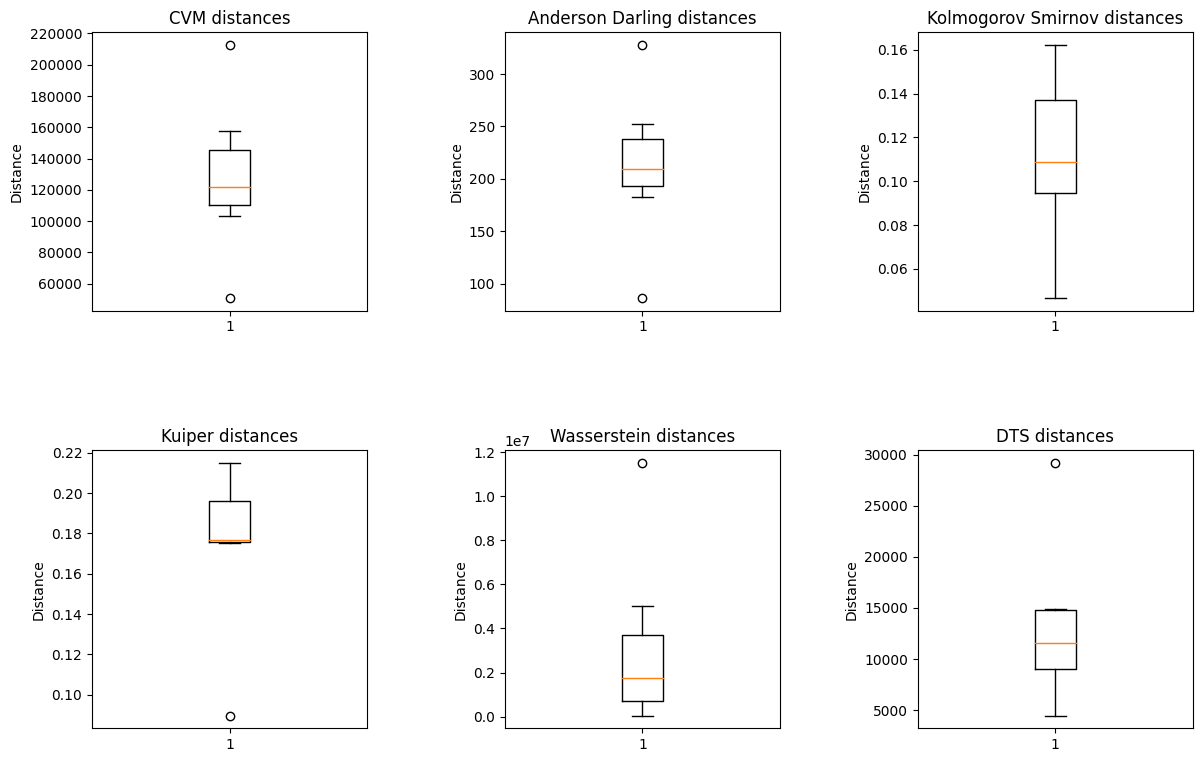

In [53]:
fig, axs = plt.subplots(2, 3)

axs[0, 0].boxplot(CVM_distances)
axs[0, 0].set_title('CVM distances')
axs[0, 0].set_ylabel("Distance")

axs[0, 1].boxplot(Anderson_Darling_distances)
axs[0, 1].set_title('Anderson Darling distances')
axs[0, 1].set_ylabel("Distance")

axs[0, 2].boxplot(Kolmogorov_Smirnov_distances)
axs[0, 2].set_title('Kolmogorov Smirnov distances')
axs[0, 2].set_ylabel("Distance")

axs[1, 0].boxplot(Kuiper_distances)
axs[1, 0].set_title("Kuiper distances")
axs[1, 0].set_ylabel("Distance")

axs[1, 1].boxplot(Wasserstein_distances)
axs[1, 1].set_title("Wasserstein distances")
axs[1, 1].set_ylabel("Distance")

axs[1, 2].boxplot(DTS_distances)
axs[1, 2].set_title("DTS distances")
axs[1, 2].set_ylabel("Distance")

fig.subplots_adjust(left=0.08, right=1.8, bottom=0.05, top=1.5, hspace=0.5, wspace=0.5)

plt.show()

In [54]:
df_final

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,label
0,-2.897031e+07,-2.136942e+06,-33115.547657,-1.805179e+06,331612.143769,-266647.959356,306874.164786,0
1,-2.890839e+07,-2.077912e+06,-33259.673301,-1.804023e+06,314009.230250,-256614.200580,306519.759479,0
2,-3.082529e+07,-2.546371e+06,-30773.012211,-1.833546e+06,954961.422721,-603447.047730,-316673.807029,0
3,-2.892029e+07,-2.096910e+06,-33217.148580,-1.804430e+06,337575.435202,-273922.857729,314964.218203,0
4,-3.082535e+07,-2.546339e+06,-30773.354609,-1.833471e+06,955061.458540,-603503.120799,-316734.588604,0
...,...,...,...,...,...,...,...,...
2827871,-3.077420e+07,-2.548007e+06,-30822.419744,-1.825043e+06,937832.133861,-589571.196769,-294109.388376,0
2827872,-3.083878e+07,-2.568404e+06,-30951.600895,-4.572670e+05,949028.056553,-601022.299393,-315503.329672,0
2827873,-3.082984e+07,-2.553585e+06,-30873.249116,-1.382320e+06,953079.628456,-602690.687234,-316378.507345,0
2827874,-2.917904e+07,-2.558580e+06,-30330.825150,-1.821424e+06,359838.667425,-178350.982734,390106.436002,0


In [55]:
# Firstly, creating the final 2D-array (Pandas Dataframe) which will be used to store the Results
# PRESERVE THE ORDERING
results_column_names = ['Accuracy', 'Anderson_Darling_dist', 'CVM_dist',
                                     'DTS_dist', 'Kolmogorov_Smirnov_dist','Kuiper_dist', 'Wasserstein_dist']
# Creating the empty Dataframe for Results
df_results = pd.DataFrame(columns = results_column_names)
# Can copy this dataframe for future results tables e.g. for each class/ label
df_results

,Accuracy,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist


In [56]:
number_of_permutations = 100

In [58]:
from tqdm import tqdm

from sklearn.model_selection import train_test_split
# 1st Set all variables needed outside for loop scope, e.g. the multi-dimensional Results array.
labels = df_final['label'].unique()
number_of_classes = len(df_final['label'].unique())

# List of Lists to hold each separate label result, using list_index->label_number mapping (for accessing)
list_of_lists_results = [[] for i in range(number_of_classes)]

for current_permutation in tqdm(range(number_of_permutations)):
    # 1.1. Cross validation, train test stratified splitting (extracted to a function, see top of file)
    #koo #X_train, X_test, y_train, y_test = get_shuffled_stratifiedKFold_train_test_split(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=114)
    
    # 1.2. Train MLP (Neural net) model using the train test data, and model.predict to get pred_y
    pred_y, accuracy = train_and_predict_Neural_Network_MLP_model(X_train, X_test, y_train, y_test)
    #koo #pred_y, accuracy = train_and_predict_LGB(X_train, X_test, y_train, y_test)
    
    # 1.3. loop over each label/ class
    for current_label in range(number_of_classes):
        
        # 1.4. Gets the correct indices for the train and test data ('X' data holds no labels)
        X_train_loc_for_label, X_test_loc_for_label = get_X_train_and_test_data_for_given_label(labels,
                                                        current_label, pred_y, X_train, X_test, y_train, y_test)
        
        # 1.5. Gets all ECDF statistical distance measures for current_label
        if len(X_test_loc_for_label):
            dict_result_row = get_statistical_dist_measures_for_class_result(accuracy,
                                                                             X_train_loc_for_label, X_test_loc_for_label)
        
        # 1.6. Append new dict row to current_label index of list of lists
        list_of_lists_results[current_label].append(dict_result_row)

100%|██████████| 100/100 [2:02:00<00:00, 73.21s/it] 


In [61]:
# Access specific dataframe by index e.g. class 1 dataframe->index 1 mapping
result_dataframes = []

for dict_result_list in list_of_lists_results:
    result_dataframes.append(pd.DataFrame(dict_result_list, columns = results_column_names))

In [60]:
# Print first dataframe result table, for class 0
result_dataframes[0].head()

,Accuracy,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0.800779,108.384657,63019.012830,13920.964943,0.061220,0.081361,2.862287e+06
1,0.783017,83.221285,46758.602109,15510.622143,0.050127,0.070110,2.126126e+06
2,0.736043,133.601270,76156.159463,13286.306135,0.071951,0.093566,3.331404e+06
3,0.801096,108.730806,63264.407722,11828.497720,0.061301,0.081462,2.819686e+06
4,0.803767,109.863736,63899.099628,11925.798453,0.061778,0.082070,2.862007e+06


In [63]:
!pip install openpyxl

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config f

In [64]:
result_dataframes[0].to_excel("Class0.xlsx")

In [65]:
# Print second dataframe result table, for class 1
result_dataframes[1].head(8)

,Accuracy,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0.800779,325.695474,32356.497639,3.971031e+05,0.966902,0.990821,3.726178e+06
1,0.783017,83.221285,46758.602109,1.551062e+04,0.050127,0.070110,2.126126e+06
2,0.736043,133.601270,76156.159463,1.328631e+04,0.071951,0.093566,3.331404e+06
3,0.801096,108.730806,63264.407722,1.182850e+04,0.061301,0.081462,2.819686e+06
4,0.803767,109.863736,63899.099628,1.192580e+04,0.061778,0.082070,2.862007e+06
5,0.800695,326.105679,30829.628225,7.990075e+06,0.912076,0.984605,4.383803e+07
6,0.802316,109.996561,64001.106047,1.193779e+04,0.061831,0.081983,2.864042e+06
7,0.813255,92.110223,53075.678709,9.693539e+03,0.049644,0.072524,2.122395e+06


In [66]:
result_dataframes[1].to_excel("Class1.xlsx")

In [67]:
concatenated = get_concatenated_results_holding_all_classes_results(number_of_classes, result_dataframes)
concatenated.head(110)

,Accuracy,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist,dataset
0,0.800779,108.384657,63019.012830,1.392096e+04,0.061220,0.081361,2.862287e+06,class0
1,0.783017,83.221285,46758.602109,1.551062e+04,0.050127,0.070110,2.126126e+06,class0
2,0.736043,133.601270,76156.159463,1.328631e+04,0.071951,0.093566,3.331404e+06,class0
3,0.801096,108.730806,63264.407722,1.182850e+04,0.061301,0.081462,2.819686e+06,class0
4,0.803767,109.863736,63899.099628,1.192580e+04,0.061778,0.082070,2.862007e+06,class0
...,...,...,...,...,...,...,...,...
5,0.800695,326.105679,30829.628225,7.990075e+06,0.912076,0.984605,4.383803e+07,class1
6,0.802316,109.996561,64001.106047,1.193779e+04,0.061831,0.081983,2.864042e+06,class1
7,0.813255,92.110223,53075.678709,9.693539e+03,0.049644,0.072524,2.122395e+06,class1
8,0.800610,109.204429,63459.694430,1.193400e+04,0.061396,0.081506,2.862076e+06,class1


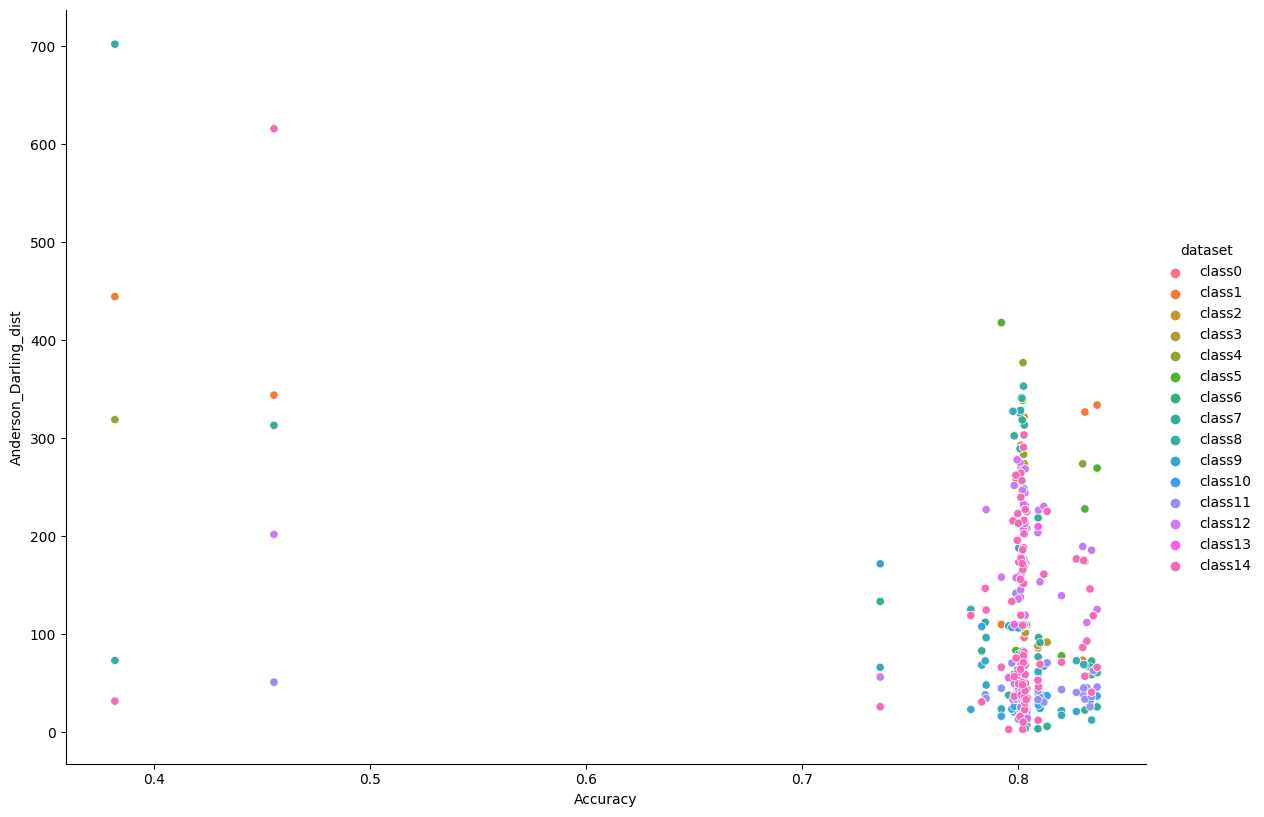

In [68]:
sns.relplot(data=concatenated, x='Accuracy', y='Anderson_Darling_dist',
                hue='dataset', height=8.27, aspect=11.7/8.27)

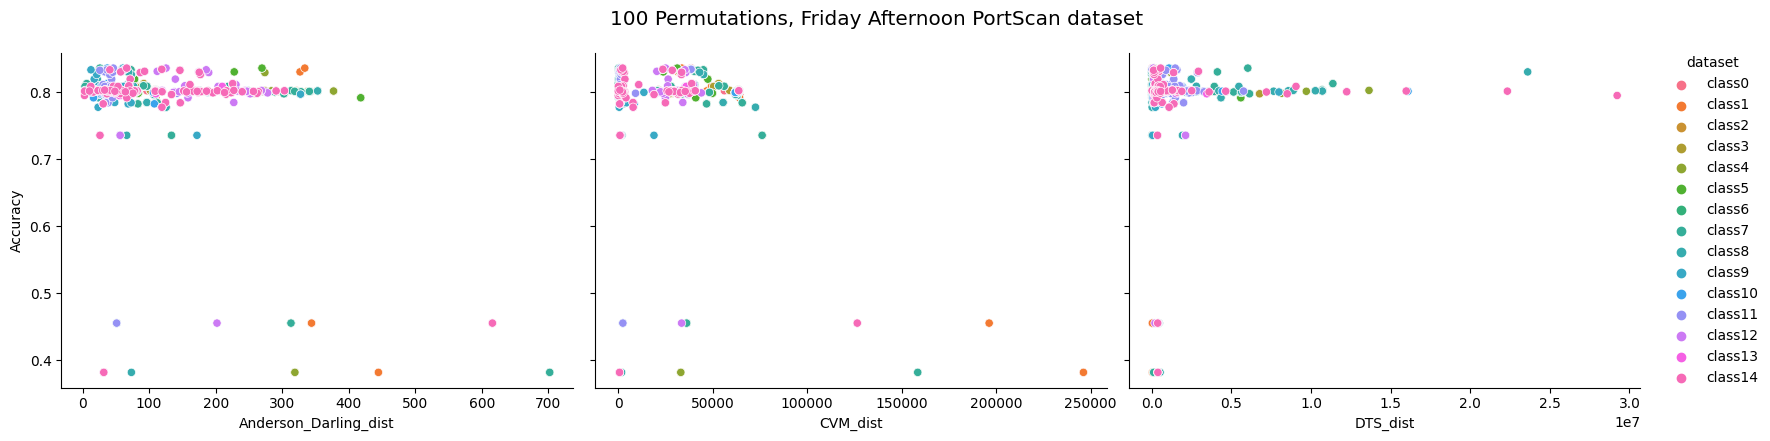

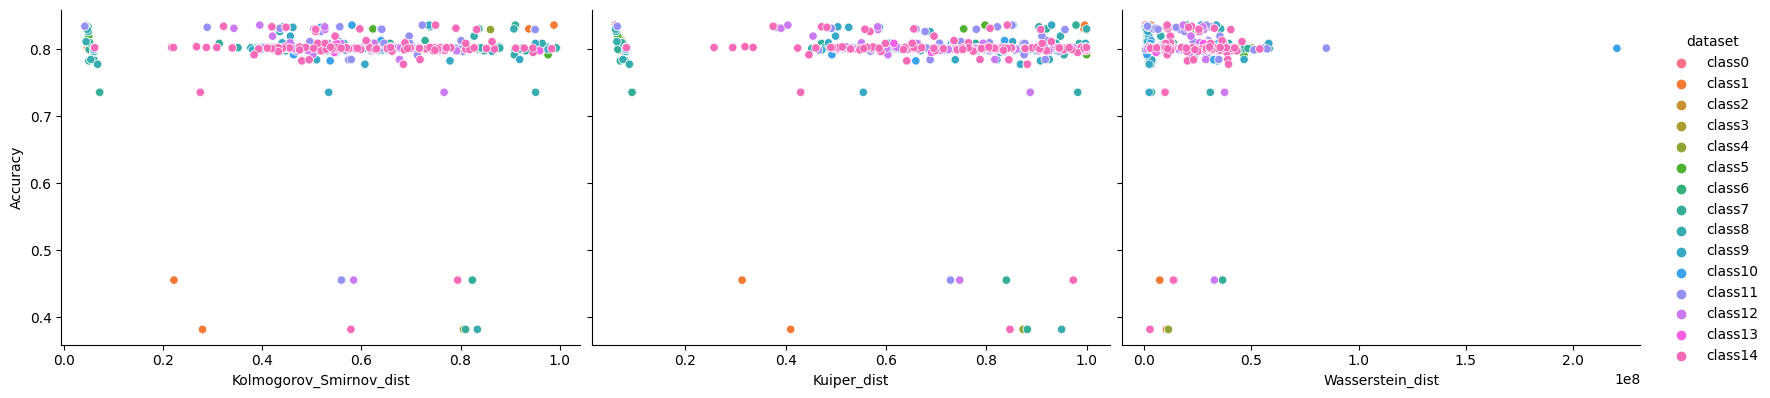

In [69]:
plot_title = "100 Permutations, Friday Afternoon PortScan dataset"

g = sns.pairplot(
    data=concatenated,
    y_vars=['Accuracy'],
    x_vars=['Anderson_Darling_dist', 'CVM_dist','DTS_dist'],
    hue='dataset',
    height=4,
    aspect=1.4
)
g.fig.suptitle(plot_title, y=1.08, fontsize='x-large')

sns.pairplot(
    data=concatenated,
    y_vars=['Accuracy'],
    x_vars=['Kolmogorov_Smirnov_dist','Kuiper_dist', 'Wasserstein_dist'],
    hue='dataset',
    height=4,
    aspect=1.4
)

<Axes: xlabel='Accuracy', ylabel='Anderson_Darling_dist'>

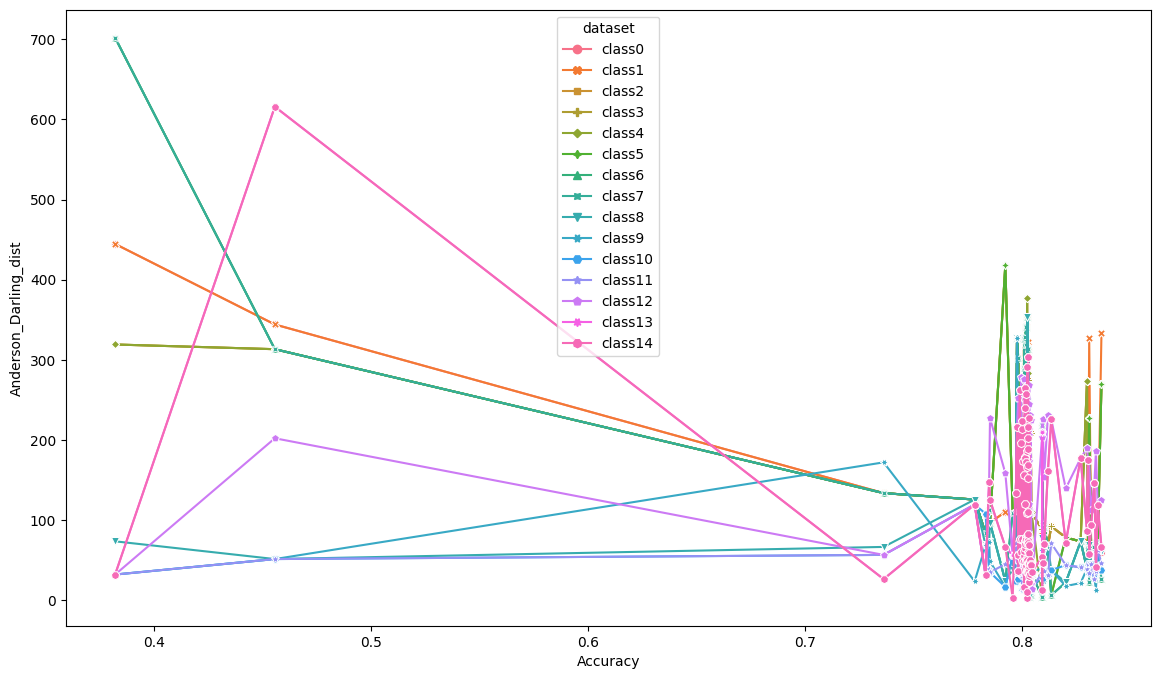

In [70]:
plt.figure(figsize=(14,8))
sns.lineplot(data=concatenated, x='Accuracy', y='Anderson_Darling_dist', hue="dataset", style="dataset",
    markers=True, dashes=False, err_style="bars", ci=40, estimator="mean")

<Axes: xlabel='Accuracy', ylabel='CVM_dist'>

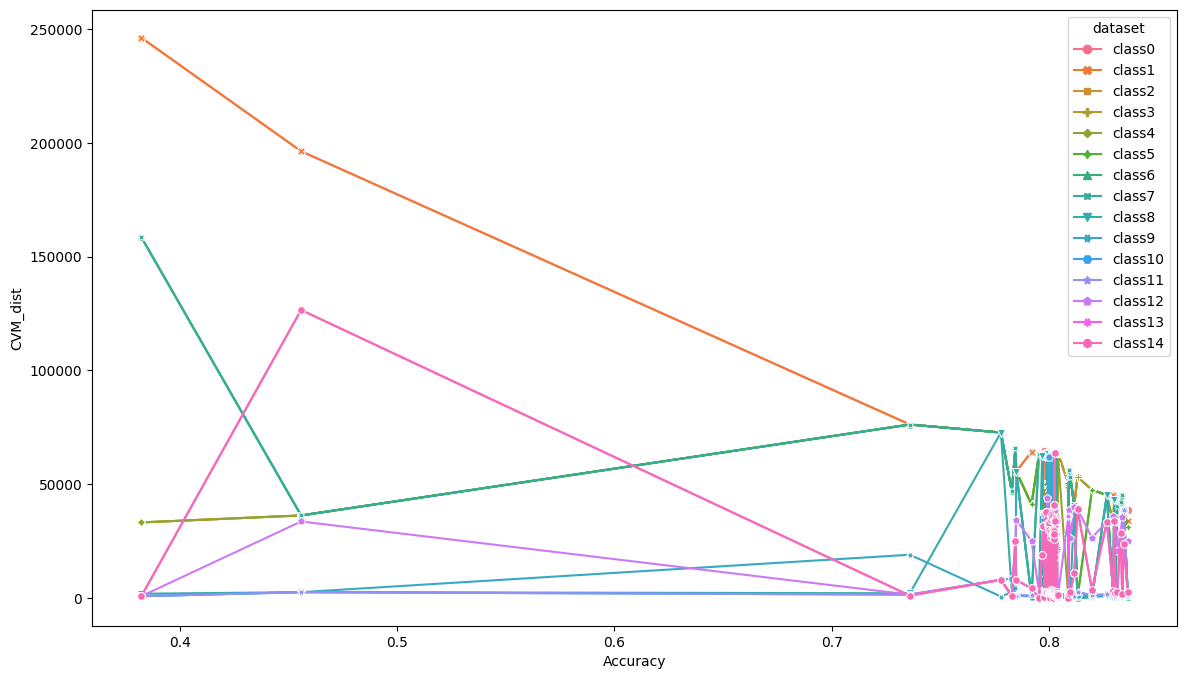

In [71]:
plt.figure(figsize=(14,8))
sns.lineplot(data=concatenated, x='Accuracy', y='CVM_dist', hue="dataset", style="dataset",
    markers=True, dashes=False)

<Axes: xlabel='Accuracy', ylabel='DTS_dist'>

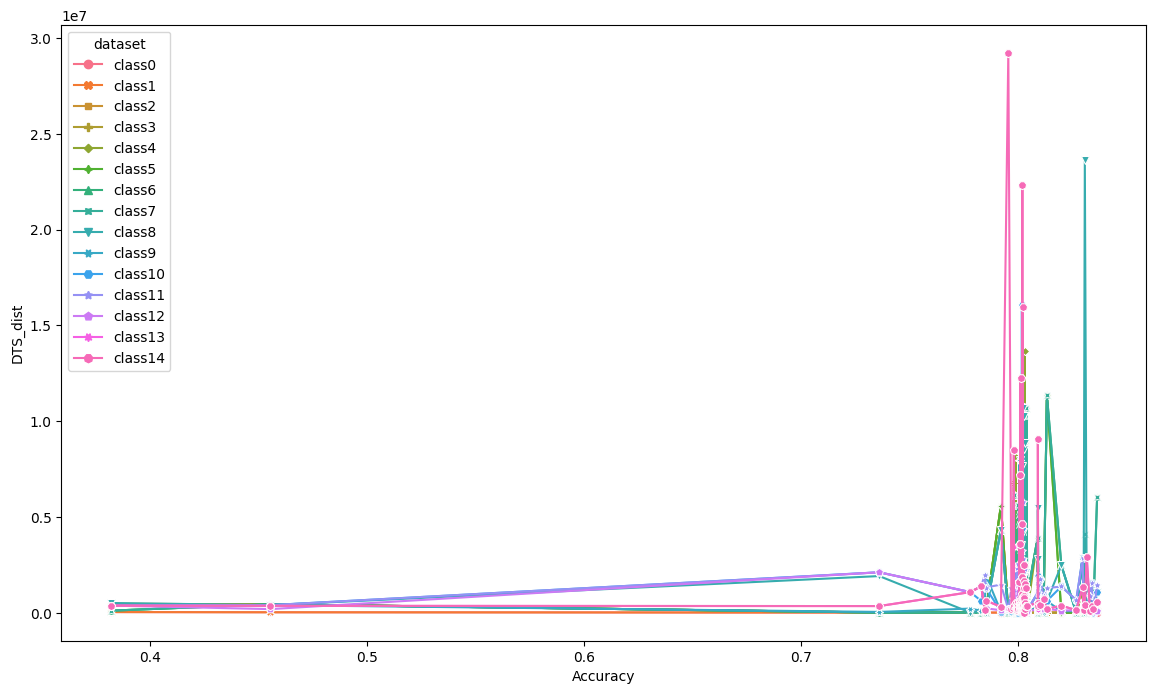

In [72]:
plt.figure(figsize=(14,8))
sns.lineplot(data=concatenated, x='Accuracy', y='DTS_dist', hue="dataset", style="dataset",
    markers=True, dashes=False)

<Axes: xlabel='Accuracy', ylabel='Kolmogorov_Smirnov_dist'>

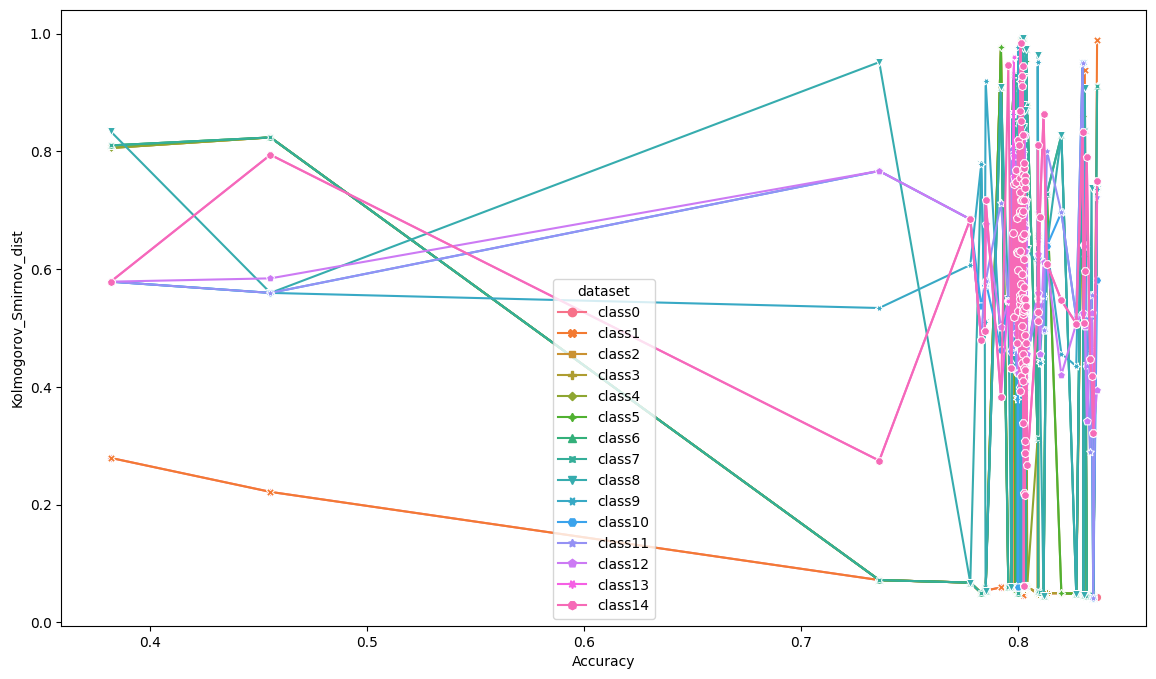

In [73]:
plt.figure(figsize=(14,8))
sns.lineplot(data=concatenated, x='Accuracy', y='Kolmogorov_Smirnov_dist', hue="dataset", style="dataset",
    markers=True, dashes=False)

<Axes: xlabel='Accuracy', ylabel='Kuiper_dist'>

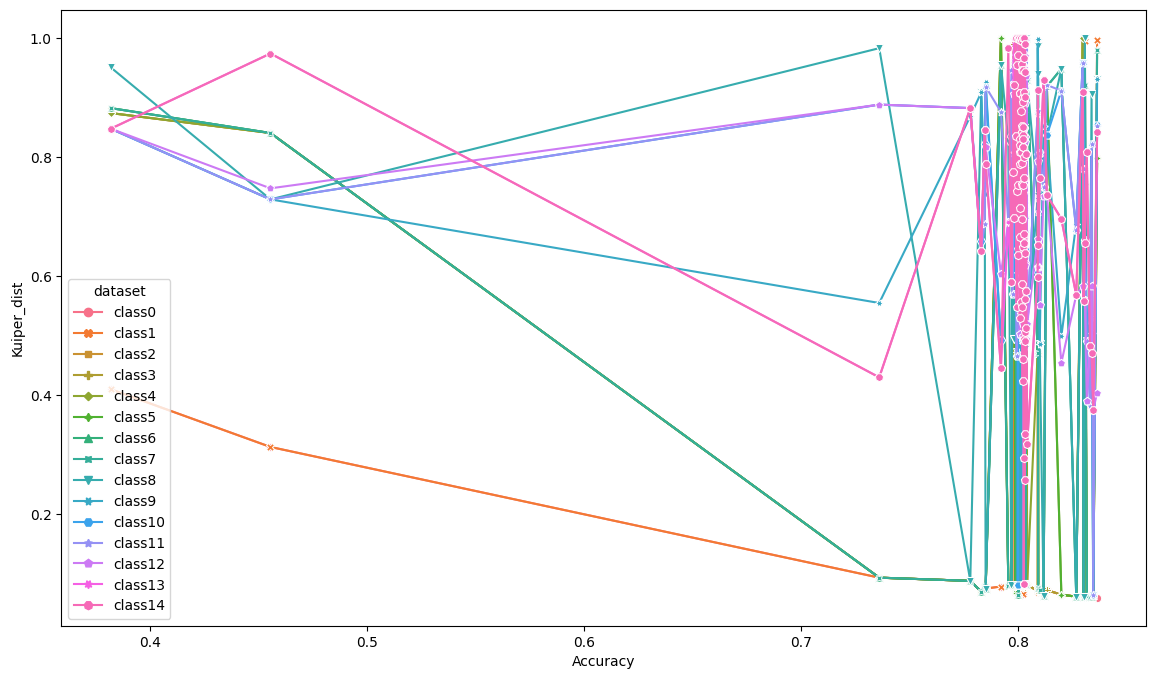

In [74]:
plt.figure(figsize=(14,8))
sns.lineplot(data=concatenated, x='Accuracy', y='Kuiper_dist', hue="dataset", style="dataset",
    markers=True, dashes=False)

<Axes: xlabel='Accuracy', ylabel='Wasserstein_dist'>

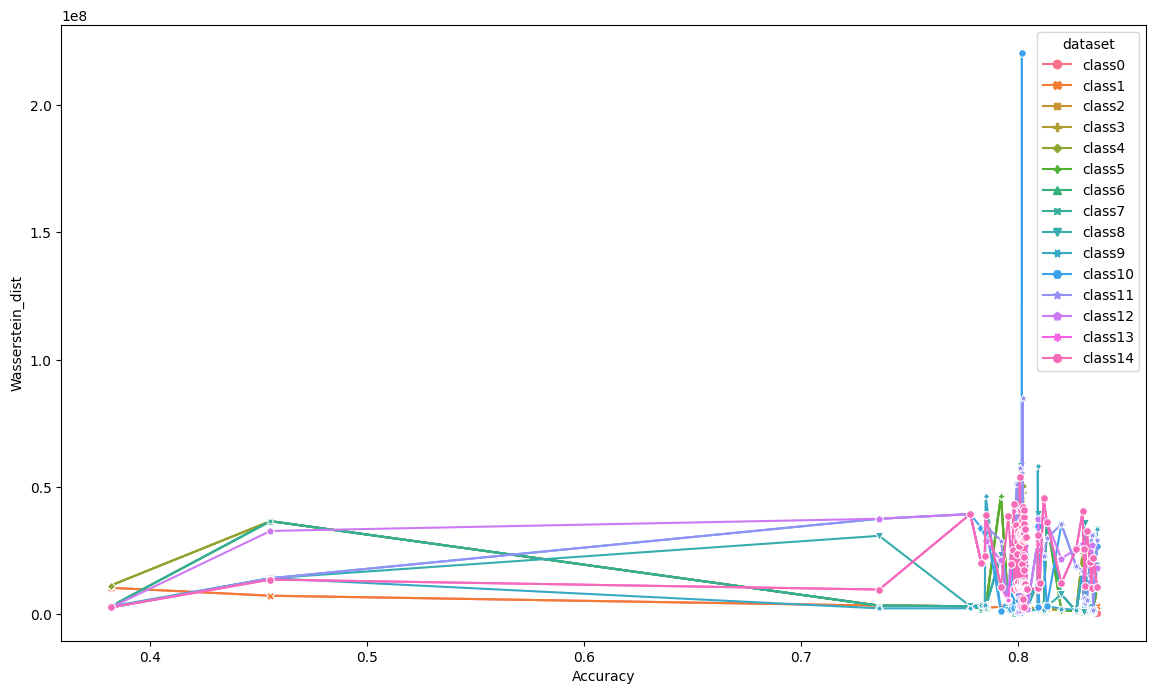

In [75]:
plt.figure(figsize=(14,8))
sns.lineplot(data=concatenated, x='Accuracy', y='Wasserstein_dist', hue="dataset", style="dataset",
    markers=True, dashes=False)

Mean Accuracy (Mu) = 79.58198349764251 %


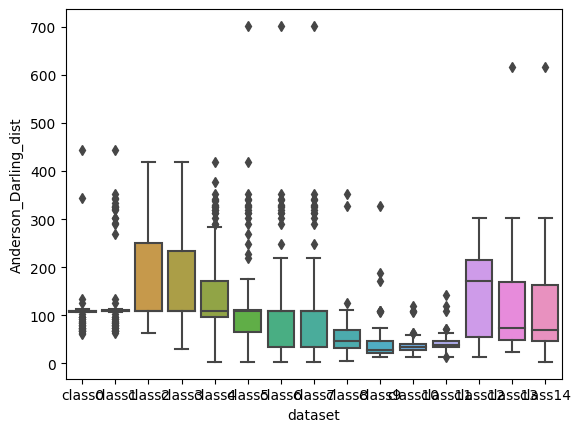

In [76]:
sns.boxplot(data=concatenated, x='dataset', y='Anderson_Darling_dist')

accuracies = concatenated['Accuracy']
mean_accuracy = accuracies[concatenated['dataset'] == 'class0'].mean()
print('Mean Accuracy (Mu) =', mean_accuracy*100, '%')

In [77]:
concatenated

,Accuracy,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist,dataset
0,0.800779,108.384657,63019.012830,1.392096e+04,0.061220,0.081361,2.862287e+06,class0
1,0.783017,83.221285,46758.602109,1.551062e+04,0.050127,0.070110,2.126126e+06,class0
2,0.736043,133.601270,76156.159463,1.328631e+04,0.071951,0.093566,3.331404e+06,class0
3,0.801096,108.730806,63264.407722,1.182850e+04,0.061301,0.081462,2.819686e+06,class0
4,0.803767,109.863736,63899.099628,1.192580e+04,0.061778,0.082070,2.862007e+06,class0
...,...,...,...,...,...,...,...,...
95,0.798912,75.814328,2517.791161,5.261142e+05,0.748435,0.834443,1.225532e+07,class14
96,0.802150,10.501774,36.142857,1.597613e+07,0.945896,0.945896,4.220792e+07,class14
97,0.801006,64.468472,2219.378774,3.946213e+05,0.630515,0.714311,1.098880e+07,class14
98,0.801627,256.798541,35443.198963,5.501264e+05,0.692921,0.790341,3.061158e+07,class14


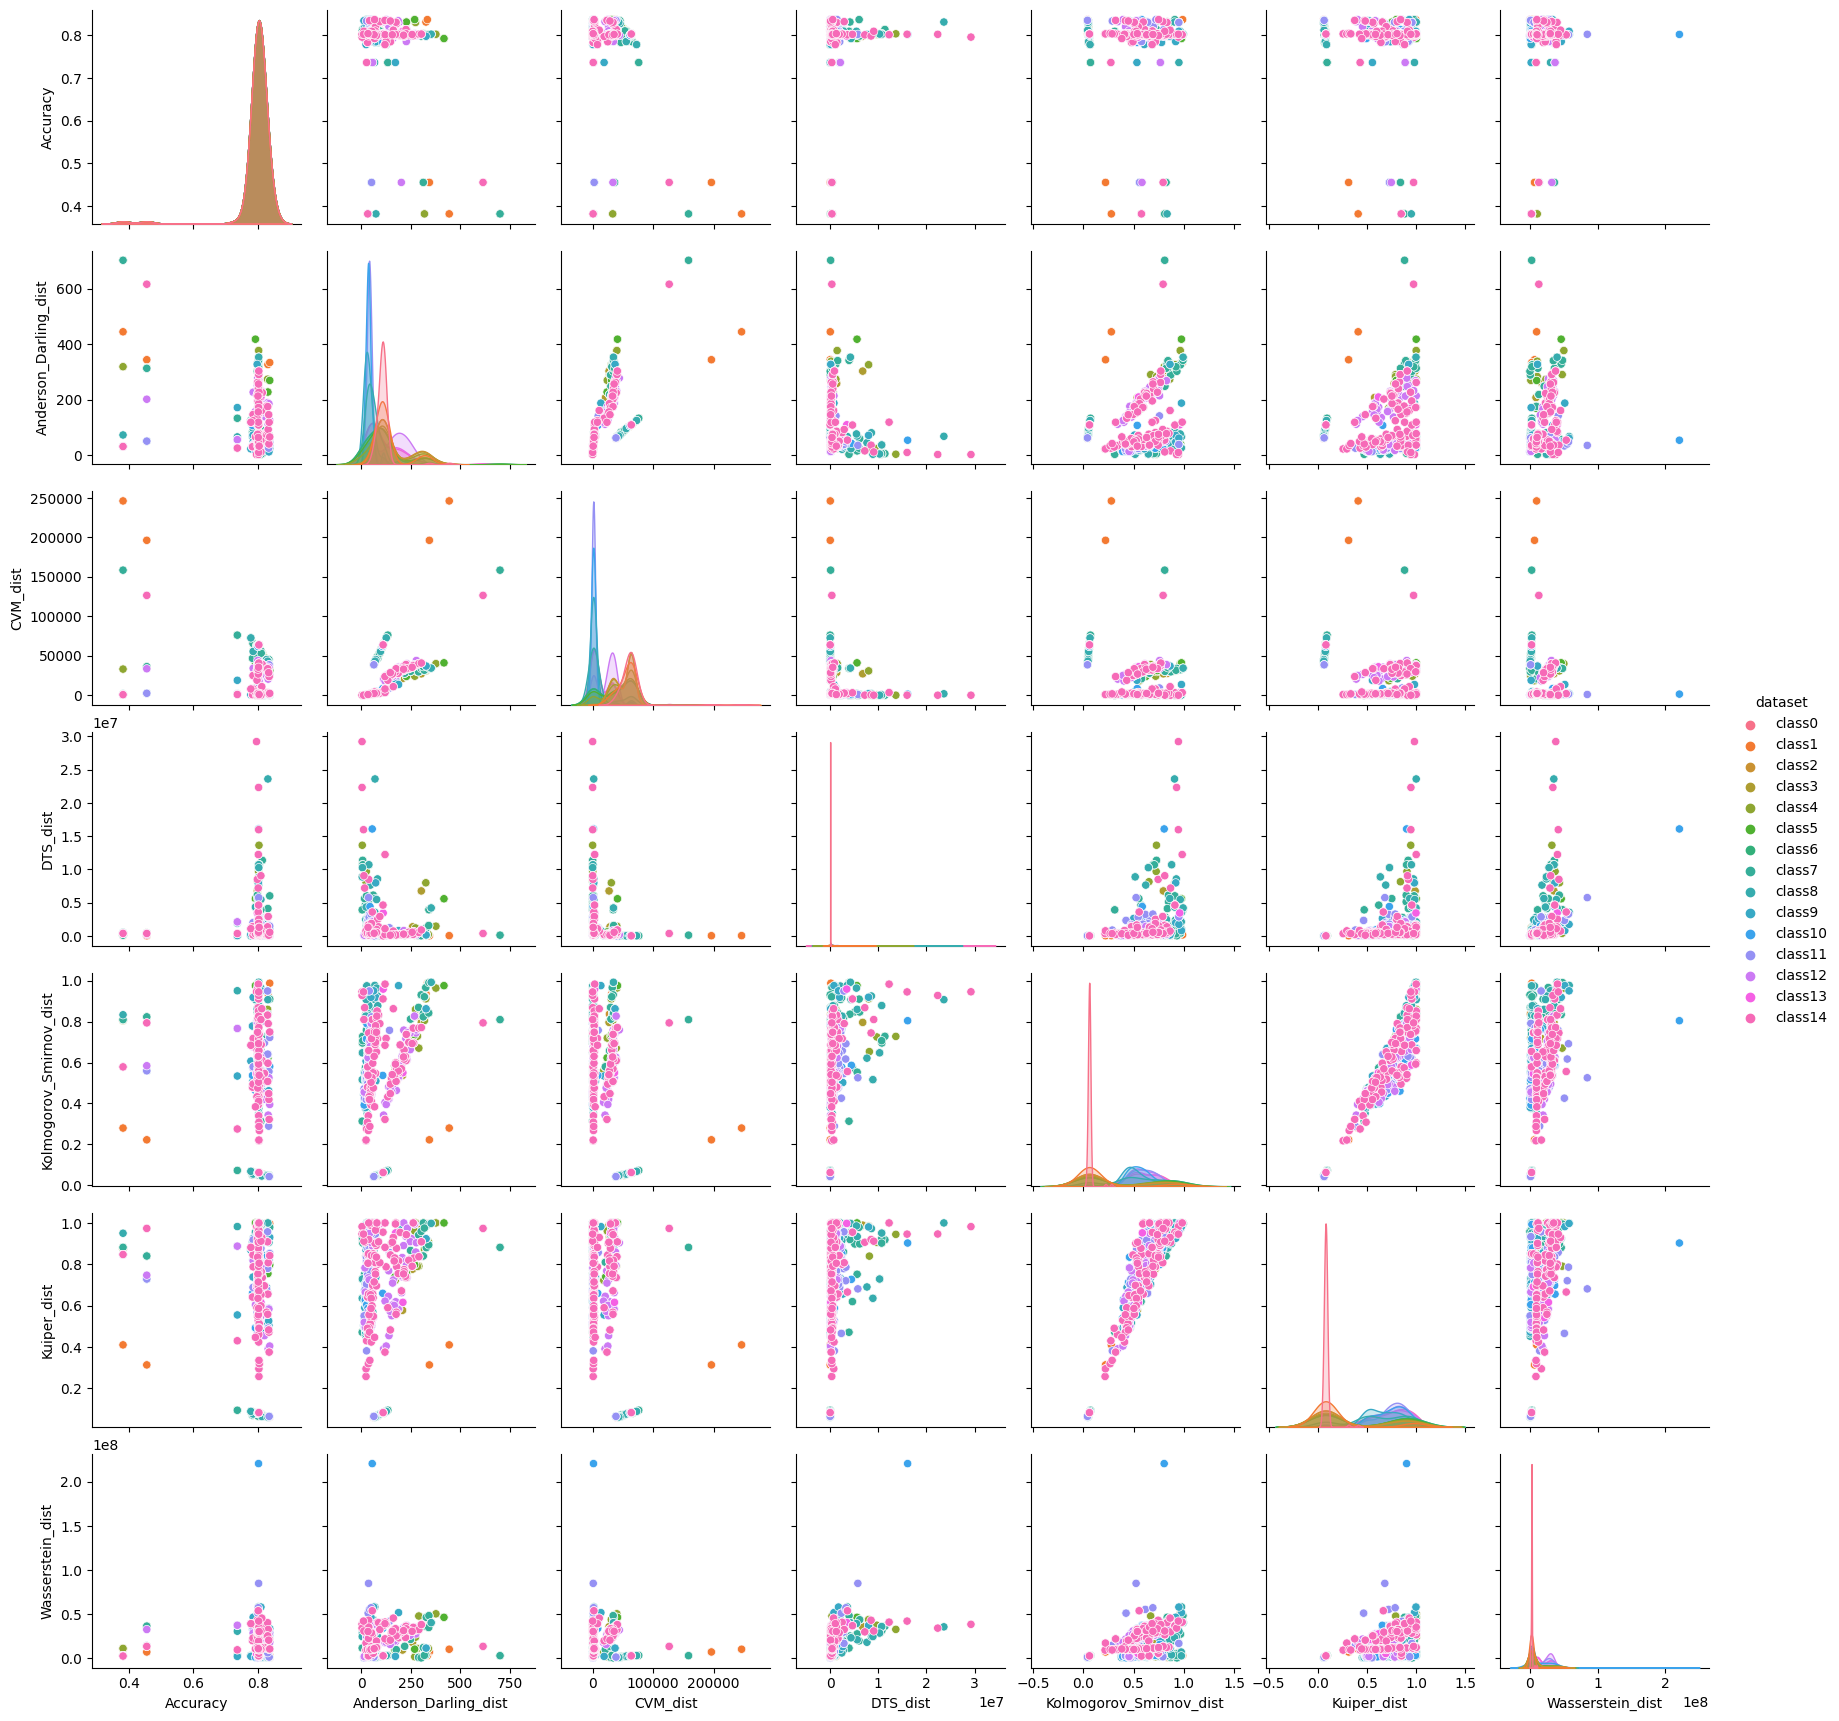

In [78]:
import seaborn as sns
sns.pairplot(concatenated, hue="dataset")


KeyboardInterrupt: 

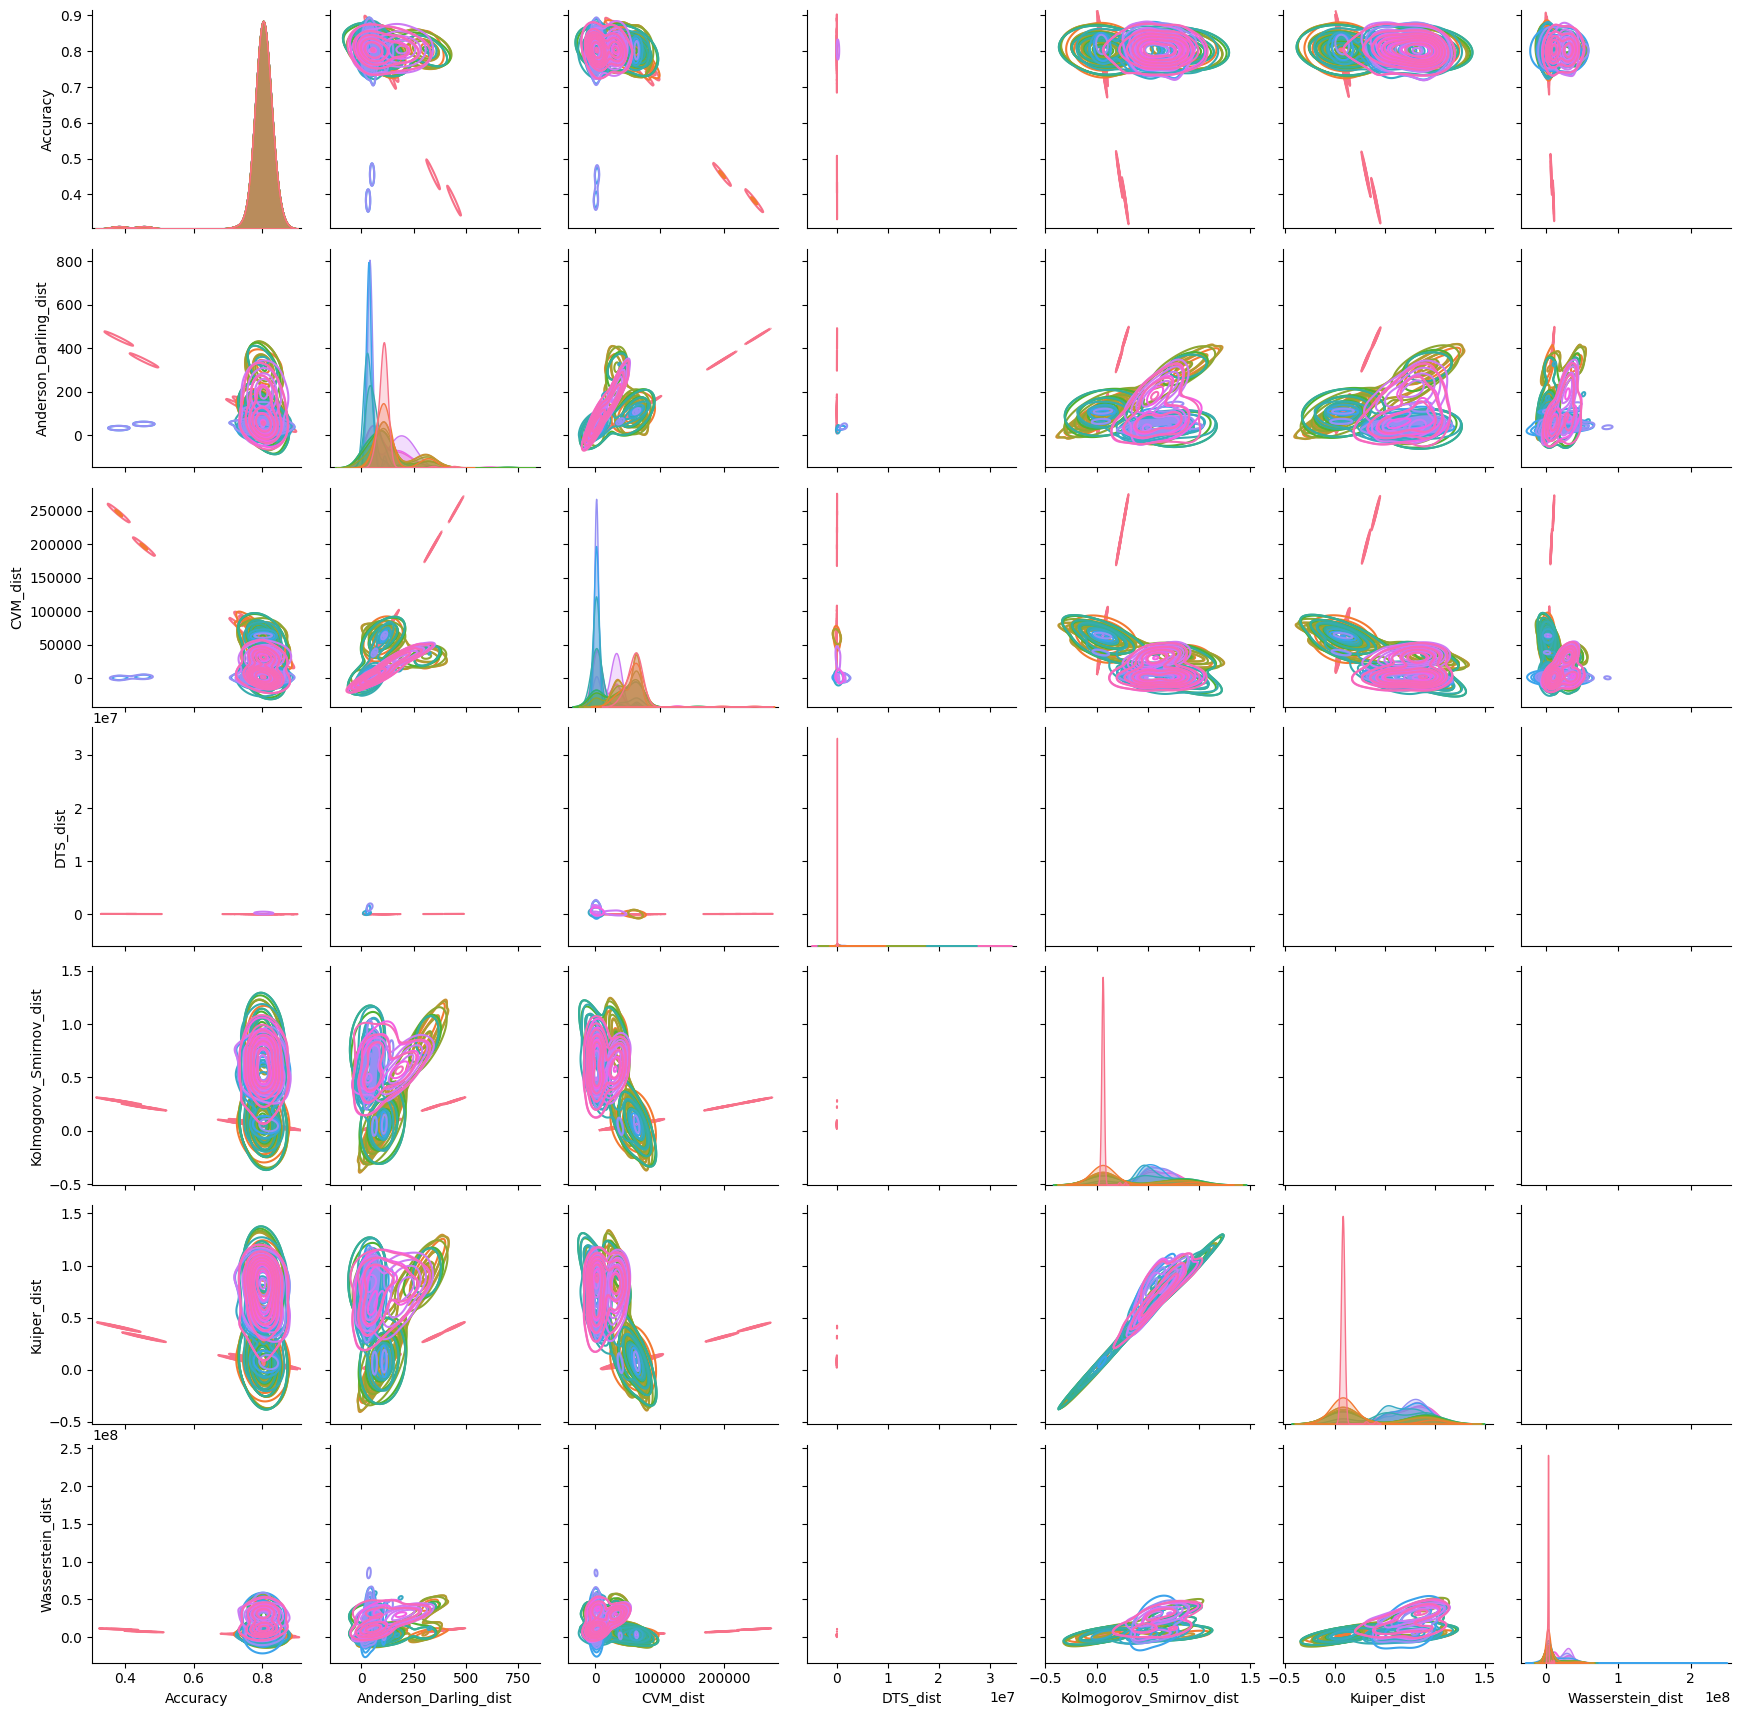

In [79]:
sns.pairplot(concatenated, kind="kde", hue="dataset")

In [81]:
import numpy as np
from scipy.special import gamma
from scipy.stats import t
import matplotlib.pyplot as plt
%matplotlib inline

def dnig(x, s, mu, nu, alpha, beta):
    """Computes the PDF of the NIG(mu, nu, alpha, beta) distribution
    
    args:
        x: float; The x coordinate of the PDF
        s: float; The s coordinate of the PDF (corresponds to sigma^2)
        mu: float; The mu parameter of NIG(mu, nu, alpha, beta)
        nu: float; The nu parameter of NIG(mu, nu, alpha, beta)
        alpha: float; The alpha parameter of NIG(mu, nu, alpha, beta)
        beta: float; The beta parameter of NIG(mu, nu, alpha, beta)
    
    return:
        float; The value of the PDF
    """
    
    if nu < 0 or alpha < 0 or beta < 0:
        raise ValueError("Cannot have negative nu, alpha, beta")
    
    return np.sqrt(nu / (np.abs(s) * 2 * np.pi)) * beta ** alpha / gamma(alpha) *\
           s**(-(alpha + 1)) * np.exp(-(2*beta + nu * (x - mu)**2)/(2*s)) * np.maximum(s, 0)

def get_posterior_nig(x, mu, nu, alpha, beta):
    """Computes the parameters of the posterior NIG distribution
    
    args:
        x: array-like; The data set
        mu: float; prior parameter mu
        nu: float; prior parameter nu
        alpha: foat; prior parameter alpha
        beta: float; prior parameter beta
    
    return:
        tuple: Of the form (mu, nu, alpha, beta)
    """
    
    if nu < 0 or alpha < 0 or beta < 0:
        raise ValueError("Cannot have negative nu, alpha, beta")
    
    xbar = x.mean()
    n = len(x)
    
    p_mu = (nu * mu + n * xbar)/(nu + n)
    p_nu = nu + n
    p_alpha = alpha + n/2
    p_beta = beta + ((x - xbar)**2).sum()/2 + n * nu / (n + nu) * (xbar - mu)**2/2
    
    return (p_mu, p_nu, p_alpha, p_beta)

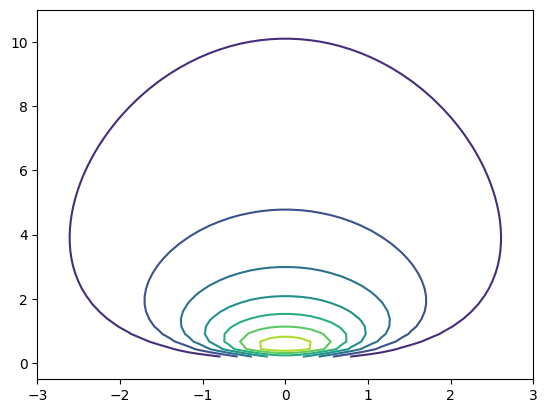

In [82]:
# Demonstrating dnig
x = np.linspace(-3, 3)
y = np.linspace(-0.5, 11)
X, Y = np.meshgrid(x, y)

plt.contour(X, Y, dnig(X, Y, 0, 1, 1/2, 1/2))
plt.show()

In [83]:
class0 = result_dataframes[0].copy()
post_x = get_posterior_nig(class0['Kolmogorov_Smirnov_dist'], 1, 1, 1/2, 0.0005)
post_x

(0.07166531394578687, 101, 50.5, 0.4743000549793955)

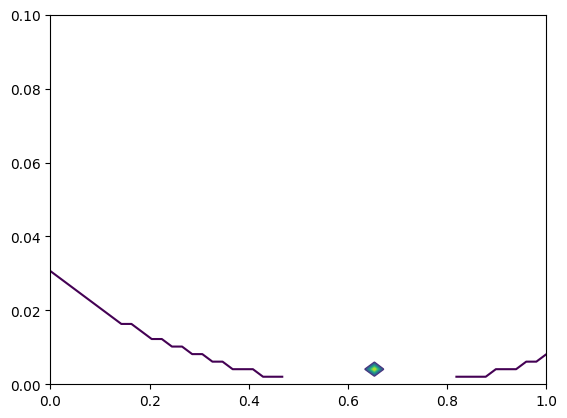

In [84]:
class0 = result_dataframes[0].copy()


mu_x = np.mean(class0['Kuiper_dist'])
var_x = np.var(class0['Kuiper_dist'])

v_x = (mu_x*(1-mu_x)/var_x)-1
alpha_x = mu_x*v_x
beta_x = (1-mu_x)*v_x

gamma_y = np.mean(class0['Accuracy'])
nu_y = var_x/v_x

x = np.linspace(0, 1)
y = np.linspace(0, 0.1)

X, Y = np.meshgrid(x, y)

plt.contour(X, Y, dnig(X, Y, 0.65, 101, 50.5, 0.2))
plt.show()